# Detecção de Fraudes em Cartões de Crédito

O objetivo deste trabalho é treinar e otimizar um modelo de rede neural para detecção de fraudes em transações de cartão de crédito.  
Primeiro, será feito um modelo **baseline**, avaliado por métricas como **precisão, recall, F1-score e AUC-ROC**.  
Em seguida, técnicas de ajuste de hiperparâmetros, como **Random Search** e **Grid Search**, para buscar melhorias no desempenho.  
Com isso, os resultados do modelo otimizado serão comparados com o modelo inicial, analisando o impacto das mudanças de hiperparâmetros nas métricas de avaliação.


In [2]:
%pip install gdown
import gdown

In [3]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=f12b37d4-a371-4a59-b2ee-fbd0aaee4b3f
To: /content/dataset.csv
100%|██████████| 151M/151M [00:02<00:00, 65.1MB/s]


'dataset.csv'

In [4]:
# Instalações e imports
!pip -q install gdown imbalanced-learn

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.utils.class_weight import compute_class_weight

from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import gdown
import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# Carregar e inspecionar rapidamente



In [6]:
df = pd.read_csv(arquivo_destino)

print("Formato:", df.shape)
print("\nPrimeiras linhas:")
display(df.head())

print("\nContagem por classe (0 = normal, 1 = fraude):")
print(df['Class'].value_counts())

fraude_rate = df['Class'].mean()
print(f"\nTaxa de fraude: {fraude_rate:.4%}")


Formato: (284807, 31)

Primeiras linhas:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Contagem por classe (0 = normal, 1 = fraude):
Class
0    284315
1       492
Name: count, dtype: int64

Taxa de fraude: 0.1727%


# Split estratificado

In [16]:
X = df.drop(columns=['Class'])
y = df['Class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED
)

print("Tamanhos -> treino:", X_train.shape, "teste:", X_test.shape)

Tamanhos -> treino: (227845, 30) teste: (56962, 30)


# Funções de avaliação

In [8]:
def avalia_modelo(modelo, X_tr, y_tr, X_te, y_te, nome="modelo"):
    # previsões
    y_pred_tr = modelo.predict(X_tr)
    y_pred_te = modelo.predict(X_te)

    # probas (para AUC)
    if hasattr(modelo, "predict_proba"):
        y_proba_tr = modelo.predict_proba(X_tr)[:, 1]
        y_proba_te = modelo.predict_proba(X_te)[:, 1]
    else:
        # fallback: decisão contínua
        y_proba_tr = modelo.decision_function(X_tr)
        y_proba_te = modelo.decision_function(X_te)

    met = {
        "modelo": nome,
        "acc_train": accuracy_score(y_tr, y_pred_tr),
        "acc_test":  accuracy_score(y_te, y_pred_te),
        "prec_test": precision_score(y_te, y_pred_te, zero_division=0),
        "recall_test": recall_score(y_te, y_pred_te, zero_division=0),
        "f1_test": f1_score(y_te, y_pred_te, zero_division=0),
        "auc_test": roc_auc_score(y_te, y_proba_te),
    }

    print(f"\n===== {nome} =====")
    print("Métricas (teste):")
    print(pd.DataFrame([{
        "Accuracy": met["acc_test"],
        "Precision": met["prec_test"],
        "Recall": met["recall_test"],
        "F1": met["f1_test"],
        "AUC-ROC": met["auc_test"],
    }]).round(4))

    print("\nRelatório de classificação (teste):")
    print(classification_report(y_te, y_pred_te, digits=4, zero_division=0))

    print("Matriz de confusão (teste):")
    print(confusion_matrix(y_te, y_pred_te))

    # curva ROC (teste)
    RocCurveDisplay.from_predictions(y_te, y_proba_te)
    plt.title(f"ROC - {nome}")
    plt.show()

    return met


# Base Line MLP


===== Baseline MLP =====
Métricas (teste):
   Accuracy  Precision  Recall      F1  AUC-ROC
0    0.9994     0.8667  0.7959  0.8298   0.9812

Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8667    0.7959    0.8298        98

    accuracy                         0.9994     56962
   macro avg     0.9332    0.8979    0.9148     56962
weighted avg     0.9994    0.9994    0.9994     56962

Matriz de confusão (teste):
[[56852    12]
 [   20    78]]


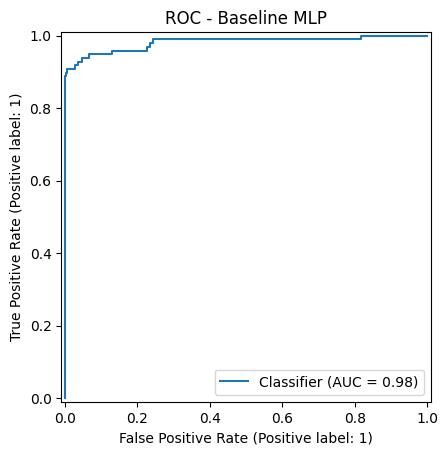

In [9]:
# Baseline MLP (sem tratamento de desbalanceamento)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 42

baseline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64,),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=200,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=RANDOM_SEED,
        verbose=False,
    ))
])

baseline.fit(X_train, y_train)

metricas_baseline = avalia_modelo(
    baseline, X_train, y_train, X_test, y_test, nome="Baseline MLP"
)


# Random Search

In [10]:

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import numpy as np

RANDOM_SEED = 42

cv_turbo = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

pipe_turbo = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_SEED, sampling_strategy=0.2)),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(32,),
        activation="relu",
        solver="adam",
        early_stopping=True,
        n_iter_no_change=8,
        max_iter=160,
        random_state=RANDOM_SEED,
        verbose=False
    ))
])


param_dist_turbo = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (64,32)],
    "mlp__alpha": np.logspace(-5, -3, 5),
    "mlp__learning_rate_init": [1e-3, 5e-4, 2e-4],
    "mlp__batch_size": [128, 256],
    "smote__sampling_strategy": [0.2]
}

rs_turbo = RandomizedSearchCV(
    estimator=pipe_turbo,
    param_distributions=param_dist_turbo,
    n_iter=8,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv_turbo,
    random_state=RANDOM_SEED,
    verbose=1
)

rs_turbo.fit(X_train, y_train)

print("Melhor AUC (CV):", rs_turbo.best_score_)
print("Melhores hiperparâmetros (turbo):")
rs_turbo.best_params_


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Melhor AUC (CV): 0.9598595993618128
Melhores hiperparâmetros (turbo):


{'smote__sampling_strategy': 0.2,
 'mlp__learning_rate_init': 0.0005,
 'mlp__hidden_layer_sizes': (64,),
 'mlp__batch_size': 128,
 'mlp__alpha': np.float64(3.1622776601683795e-05)}

# Avaliar melhor do Random Search



===== RandomSearch MLP (turbo) =====
Métricas (teste):
   Accuracy  Precision  Recall      F1  AUC-ROC
0    0.9992     0.7619  0.8163  0.7882   0.9624

Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.9997    0.9996    0.9996     56864
           1     0.7619    0.8163    0.7882        98

    accuracy                         0.9992     56962
   macro avg     0.8808    0.9079    0.8939     56962
weighted avg     0.9993    0.9992    0.9993     56962

Matriz de confusão (teste):
[[56839    25]
 [   18    80]]


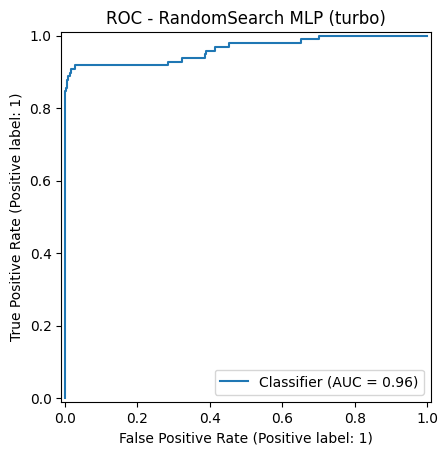

,modelo,acc_test,prec_test,recall_test,f1_test,auc_test
0,Baseline MLP,0.9994,0.8667,0.7959,0.8298,0.9812
1,RandomSearch MLP (turbo),0.9992,0.7619,0.8163,0.7882,0.9624
2,RandomSearch MLP (turbo),0.9992,0.7619,0.8163,0.7882,0.9624


In [11]:
best_random = rs_turbo.best_estimator_
metricas_random = avalia_modelo(
    best_random, X_train, y_train, X_test, y_test, nome="RandomSearch MLP (turbo)"
)


comparar = [m for m in [
    globals().get("metricas_baseline"),
    globals().get("metricas_baseline_smote"),
    globals().get("metricas_grid"),
    globals().get("metricas_random"),
    metricas_random
] if m is not None]

if comparar:
    display(pd.DataFrame(comparar)[
        ["modelo","acc_test","prec_test","recall_test","f1_test","auc_test"]
    ].sort_values("auc_test", ascending=False).reset_index(drop=True).round(4))


# Grid Search

Fitting 2 folds for each of 24 candidates, totalling 48 fits
Melhor AUC (CV): 0.9587733045378484
Melhores hiperparâmetros (grid 24 combos):
{'mlp__alpha': 0.0001, 'mlp__batch_size': 128, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__learning_rate_init': 0.001}

===== GridSearch MLP (24 combos) =====
Métricas (teste):
   Accuracy  Precision  Recall      F1  AUC-ROC
0    0.9991     0.6923  0.8265  0.7535   0.9657

Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9995     56864
           1     0.6923    0.8265    0.7535        98

    accuracy                         0.9991     56962
   macro avg     0.8460    0.9129    0.8765     56962
weighted avg     0.9992    0.9991    0.9991     56962

Matriz de confusão (teste):
[[56828    36]
 [   17    81]]


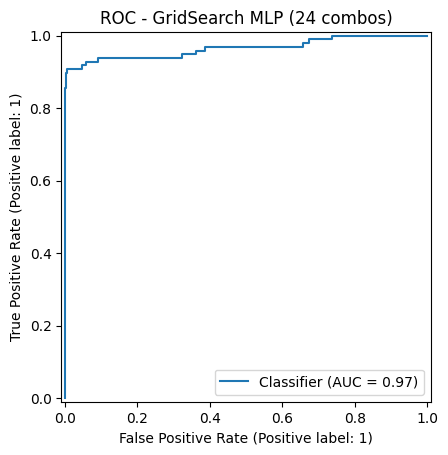

In [12]:
# GRID SEARCH 24 COMBOS — cv=2 → 48 fits (rápido e completo)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 42

pipe_grid = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_SEED, sampling_strategy=0.2)),
    ("mlp", MLPClassifier(
        activation="relu",
        solver="adam",
        early_stopping=True,
        n_iter_no_change=8,
        max_iter=180,
        random_state=RANDOM_SEED
    ))
])

# === 3 x 2 x 2 x 2 = 24 combinações ===
grid_24 = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (64,32)],  # 3
    "mlp__alpha": [1e-4, 5e-4],                          # 2
    "mlp__learning_rate_init": [1e-3, 5e-4],             # 2
    "mlp__batch_size": [128, 256],                       # 2
}

cv2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

gs_24 = GridSearchCV(
    estimator=pipe_grid,
    param_grid=grid_24,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv2,
    verbose=1
)

gs_24.fit(X_train, y_train)

print("Melhor AUC (CV):", gs_24.best_score_)
print("Melhores hiperparâmetros (grid 24 combos):")
print(gs_24.best_params_)

best_grid = gs_24.best_estimator_
metricas_grid = avalia_modelo(best_grid, X_train, y_train, X_test, y_test,
                              nome="GridSearch MLP (24 combos)")


# Avaliar melhor do Grid Search


===== GridSearch MLP (24 combos) =====
Métricas (teste):
   Accuracy  Precision  Recall      F1  AUC-ROC
0    0.9991     0.6923  0.8265  0.7535   0.9657

Relatório de classificação (teste):
              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9995     56864
           1     0.6923    0.8265    0.7535        98

    accuracy                         0.9991     56962
   macro avg     0.8460    0.9129    0.8765     56962
weighted avg     0.9992    0.9991    0.9991     56962

Matriz de confusão (teste):
[[56828    36]
 [   17    81]]


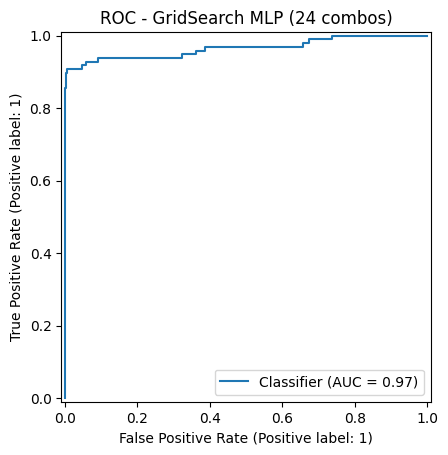

In [14]:
best_grid = gs_24.best_estimator_
metricas_grid = avalia_modelo(
    best_grid, X_train, y_train, X_test, y_test,
    nome="GridSearch MLP (24 combos)"
)

# Comparação final

In [15]:

tabela = pd.DataFrame([metricas_baseline, metricas_random, metricas_grid])[
    ["modelo","acc_test","prec_test","recall_test","f1_test","auc_test"]
].sort_values("auc_test", ascending=False).reset_index(drop=True)

print("Comparação (ordenado por AUC):")
display(tabela.round(4))


Comparação (ordenado por AUC):


,modelo,acc_test,prec_test,recall_test,f1_test,auc_test
0,Baseline MLP,0.9994,0.8667,0.7959,0.8298,0.9812
1,GridSearch MLP (24 combos),0.9991,0.6923,0.8265,0.7535,0.9657
2,RandomSearch MLP (turbo),0.9992,0.7619,0.8163,0.7882,0.9624
